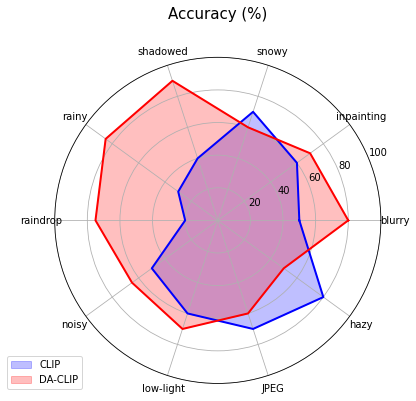

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
categories = ['blurry', 'inpainting', 'snowy', 'shadowed', 'rainy', 'raindrop', 'noisy', 'low-light', 'JPEG', 'hazy']
clip_values = [50, 60, 70, 40, 30, 20, 50, 60, 70, 80]
da_clip_values = [80, 70, 60, 90, 85, 75, 65, 70, 60, 50]

# 数据处理
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
clip_values += clip_values[:1]
da_clip_values += da_clip_values[:1]
angles += angles[:1]

# 设置图形
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, clip_values, color='blue', alpha=0.25, label='CLIP')
ax.fill(angles, da_clip_values, color='red', alpha=0.25, label='DA-CLIP')
ax.plot(angles, clip_values, color='blue', linewidth=2)
ax.plot(angles, da_clip_values, color='red', linewidth=2)

# 填充和标签
ax.set_yticks([20, 40, 60, 80, 100])
ax.set_yticklabels(['20', '40', '60', '80', '100'])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

# 标题和图例
plt.title('Accuracy (%)', size=15, color='black', y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()


In [3]:
from matplotlib.patches import Rectangle,Circle
import imageio
import matplotlib.pyplot as plt
import numpy as np
import glob
from torchmetrics.functional import peak_signal_noise_ratio,structural_similarity_index_measure
import torch.nn.functional as F
import torch
from util import transforms


from PIL import Image
from skimage.util import compare_images
import skimage


from skimage.metrics import mean_squared_error as compare_mse
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
import cv2


def sorted_list(path): 
    
    
    """ function for getting list of files or directories. """
    
    tmplist = glob.glob(path) # finding all files or directories and listing them.
    tmplist.sort() # sorting the found list
    
    return tmplist

45.88610833333334

In [4]:
from matplotlib.patches import Rectangle,Circle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
def read_image(path,num,window_size=(-1000,2000)):
    path= '/data/zhchen/CLDN/test_results'+path+'test/'+str('%04d' % num)+'.png'
    img = Image.open(path)
    data = np.array(img, dtype='uint16')[:,:,0]
    f_img=data.astype(np.float32)/255
#     if window_size is not None:
#         f_img=np.clip(f_img*3000-1000,window_size[0],window_size[1])
    return f_img

def draw_images(labels,num,window_size=(-1000,2000),res_window_size=(-1000,2000),
                top_left_x=100, top_left_y=100,width=100, height=100):
    
#     labels=['LDCT_png','NDCT_png','unet','redcnn','dformer_png',
#             'pix_gan','CLDN_14','CLDN_14_3','CLDN_15_1','CLDN_15_2','CLDN_15_4','CLDN_18_2']

#     labels=['LDCT_png','NDCT_png','unet','redcnn','dformer_png',
#             'pix_gan','CLDN_14','CLDN_15_2','CLDN_15_4','CLDN_18_3','CLDN_19_2','CLDN_19_3']

#     labels=['LDCT_png','NDCT_png','unet','redcnn','dformer_png','pix_gan',
#             'DUGAN_1','CLDN_15_2','CLDN_15_4','CLDN_18_3','CLDN_19_2','CLDN_19_4']

    
    
    images=[]
    for i,label in enumerate(labels):
        image=read_image('/'+label+'/',num=num,window_size=window_size)
        #print(image.max(),image.min())
        images.append(image)
        
    
    res_images=[]
    row=len(labels)
    for m in range(len(images)):
        #res_img=compare_images(images[m],images[0],method='diff')
        res_img=abs(images[0]-images[m])
#         if m==len(images)-2:
#             res_images.append(np.clip(res_img,res_window_size[0],res_window_size[1]+3))
#         elif m==len(images)-1:
#             res_images.append(np.clip(res_img,res_window_size[0],res_window_size[1]+7))
#         else:
#             res_images.append(np.clip(res_img,res_window_size[0],res_window_size[1]))
        res_images.append(np.clip(res_img,0,0.2))
    print(res_images[1].min())
    print(res_images[2].max())
    print(len(res_images))
    
    plt.figure(figsize=(16,5),dpi=300)
    plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.05,hspace=0.05)
    for n in range(len(images)):
        plt.subplot(3,row,n+1)
        plt.imshow(images[n].squeeze(),cmap='gray')
        if n==0:
            plt.gca().add_patch(Rectangle((top_left_x, top_left_y), width, height, edgecolor='red',
                            facecolor='none',
                            lw=1))
        if n != 0:
            ssim=compare_ssim(images[n],images[0],data_range=window_size[1]-window_size[0])
            psnr=compare_psnr(images[n],images[0],data_range=window_size[1]-window_size[0])
            plt.title(labels[n]+'\n'+str('%.4f' % psnr)+','+str('%.4f' % ssim),fontsize=8)
            
        plt.axis('off')
        
    
    #plt.figure(figsize=(7,3),dpi=2000)
    #plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.1,hspace=0.1)
    for n in range(len(images)):
        plt.subplot(3,row,row+n+1)
        plt.imshow(np.clip(images[n].squeeze()[top_left_y:top_left_y+height,top_left_x:top_left_x+width],-160,240),cmap='gray')
        plt.axis('off')
    #plt.savefig('slice_'+str(num)+'.pdf',dpi=1000)
    
#     plt.figure(figsize=(8,3),dpi=1000)
#     plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.15,hspace=0.15)
#     for n in range(len(res_images)):
#         plt.subplot(2,8,n+1)
#         plt.imshow(res_images[n].squeeze(),cmap='gray_r')
#         #plt.title(labels[n]+',\n '+str('%.4f' %res_images[n].mean()),fontsize=5)
#         plt.axis('off')
    
    #plt.savefig('slice_'+str(num)+'.pdf',dpi=1000)


# create an Axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.

    #plt.figure(figsize=(8,3),dpi=2000)
    #
    for n in range(len(res_images)):
        plt.subplot(3,row,row*2+n+1)
        if n==0:
            #cbar_ax = fig.add_axes([0.91, 0.025, 0.04, 0.95])
            im=plt.imshow(np.random.uniform(0,1,[512,512]),vmin=0,vmax=50,cmap='Greys')
            cbar1=plt.colorbar(im)
            tick_locator = ticker.MaxNLocator(nbins=3) 
            cbar1.locator = tick_locator
            cbar1.set_ticks([0,10,20,30,40,50])
            cbar1.update_ticks()
            cbar1.update_ticks()
            cbar1.ax.tick_params(labelsize=5)   
        #plt.imshow(res_images[n].squeeze()[top_left_y:top_left_y+height,top_left_x:top_left_x+width],cmap='Greys')
        plt.imshow(res_images[n].squeeze(),cmap='Greys')
        
        #plt.title(labels[n]+', '+str('%.4f' %res_images[n].mean()),fontsize=5)
        plt.axis('off')
    

    
#     cbar_ax = fig.add_axes([0.91, 0.025, 0.04, 0.95])
#     cbar1=fig.colorbar(im, cax=cbar_ax)
#     tick_locator = ticker.MaxNLocator(nbins=3)  # colorbar上的刻度值个数
#     cbar1.locator = tick_locator
#     cbar1.set_ticks([0, 0.5, 1])
#     cbar1.update_ticks()
#     cbar1.ax.tick_params(labelsize=300,which='major',length=200,width=50)                
                

4344